In [14]:
import os
import fastf1
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go

from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [15]:
cache_dir = "cache"
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

fastf1.Cache.enable_cache(cache_dir)

session = fastf1.get_session(2023, "Monaco", "Q")
session.load()
display(session.laps.columns)

core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '16', '31', '55', '44', '10', '63', '22', '4', '81', '21', '23', '18', '77', '2', '20', '27', '24', '11']


Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='object')

In [16]:
lap_alo = session.laps.pick_driver("ALO").query("LapNumber == 24").iloc[0]
lap_ver = session.laps.pick_driver("VER").query("LapNumber == 29").iloc[0]

tel_alo = lap_alo.get_telemetry().add_distance()
tel_ver = lap_ver.get_telemetry().add_distance()

tel_ver["RelTime"] = (tel_ver["Time"] - tel_ver["Time"].iloc[0]).dt.total_seconds()
tel_alo["RelTime"] = (tel_alo["Time"] - tel_alo["Time"].iloc[0]).dt.total_seconds()

min_dist = 0
max_dist = min(tel_ver["Distance"].max(), tel_alo["Distance"].max())
ref_dist = np.linspace(min_dist, max_dist, 3000)

c:\Users\alejandro.barea\UOC\VISUALIZACION_DATOS\PRACTICAFINAL\pracfinalentorno\Lib\site-packages\fastf1\core.py:3081: FutureWarning:

pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.

c:\Users\alejandro.barea\UOC\VISUALIZACION_DATOS\PRACTICAFINAL\pracfinalentorno\Lib\site-packages\fastf1\core.py:3081: FutureWarning:

pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.



In [17]:
v_alo = np.interp(ref_dist, tel_alo['Distance'], tel_alo['Speed'])
v_ver = np.interp(ref_dist, tel_ver['Distance'], tel_ver['Speed'])

eps = 1e-6
v_ver = np.maximum(v_ver, eps)
v_alo = np.maximum(v_alo, eps)

ds = np.gradient(ref_dist)

v_ver_s = savgol_filter(v_ver, 21, 3)
v_alo_s = savgol_filter(v_alo, 21, 3)

delta_time = np.cumsum((1 / v_alo_s - 1 / v_ver_s) * ds * 3.6)
delta_time = delta_time - delta_time[0]

t_ver = np.interp(ref_dist, tel_ver["Distance"], tel_ver["RelTime"])
t_alo = np.interp(ref_dist, tel_alo["Distance"], tel_alo["RelTime"])

thr_alo = np.interp(ref_dist, tel_alo['Distance'], tel_alo['Throttle'])
thr_ver = np.interp(ref_dist, tel_ver['Distance'], tel_ver['Throttle'])

In [18]:
s1_end_dist = np.interp(lap_ver["Sector1Time"].total_seconds(), 
                        tel_ver["Time"].dt.total_seconds(), tel_ver["Distance"])
s2_end_dist = np.interp((lap_ver["Sector1Time"] + lap_ver["Sector2Time"]).total_seconds(), 
                        tel_ver["Time"].dt.total_seconds(), tel_ver["Distance"])

In [19]:
corners = {"Santa Devota": 140, "Massenet": 690, "Casino": 890,
    "Loebs": 1230, "Portier": 1400, "Tunnel": 1600, "Chicane": 2080,
    "Tabac": 2330, "Piscina": 2690, "Rascasse": 2875}

In [20]:
n_points = len(ref_dist)
df_tel = pd.DataFrame({'Distance': np.tile(ref_dist, 2),'Speed': np.concatenate([v_ver, v_alo]),
    'Throttle': np.concatenate([thr_ver, thr_alo]),'Driver': ['VER']*n_points + ['ALO']*n_points})

df_delta = pd.DataFrame({'Distance': ref_dist, 'Delta': delta_time})

In [21]:
df_tel = pd.concat([tel_ver.assign(Driver="VER"),tel_alo.assign(Driver="ALO")])[["Distance", "Speed", "Throttle", "Brake", "Driver"]]

df_tel["Brake"] = df_tel["Brake"].astype(int)

In [22]:
def plot_variable(df, var, y_label, title):
    fig = px.line(df,x="Distance",y=var,color="Driver",title=title,labels={"Distance": "Distancia (m)", var: y_label})

    fig.add_vline(x=s1_end_dist, line_dash="dot", annotation_text="Fin S1", annotation_position="top")
    fig.add_vline(x=s2_end_dist, line_dash="dot", annotation_text="Fin S2", annotation_position="top")

    for name, dist in corners.items():
        fig.add_vline(x=dist, line_dash="dash", annotation_text=name, annotation_position="top")

    fig.show()


In [23]:
plot_variable(df_tel, "Speed", "km/h", "Velocidad a lo largo de la vuelta")
plot_variable(df_tel, "Throttle", "%", "Acelerador a lo largo de la vuelta")
plot_variable(df_tel, "Brake", "", "Frenada a lo largo de la vuelta")

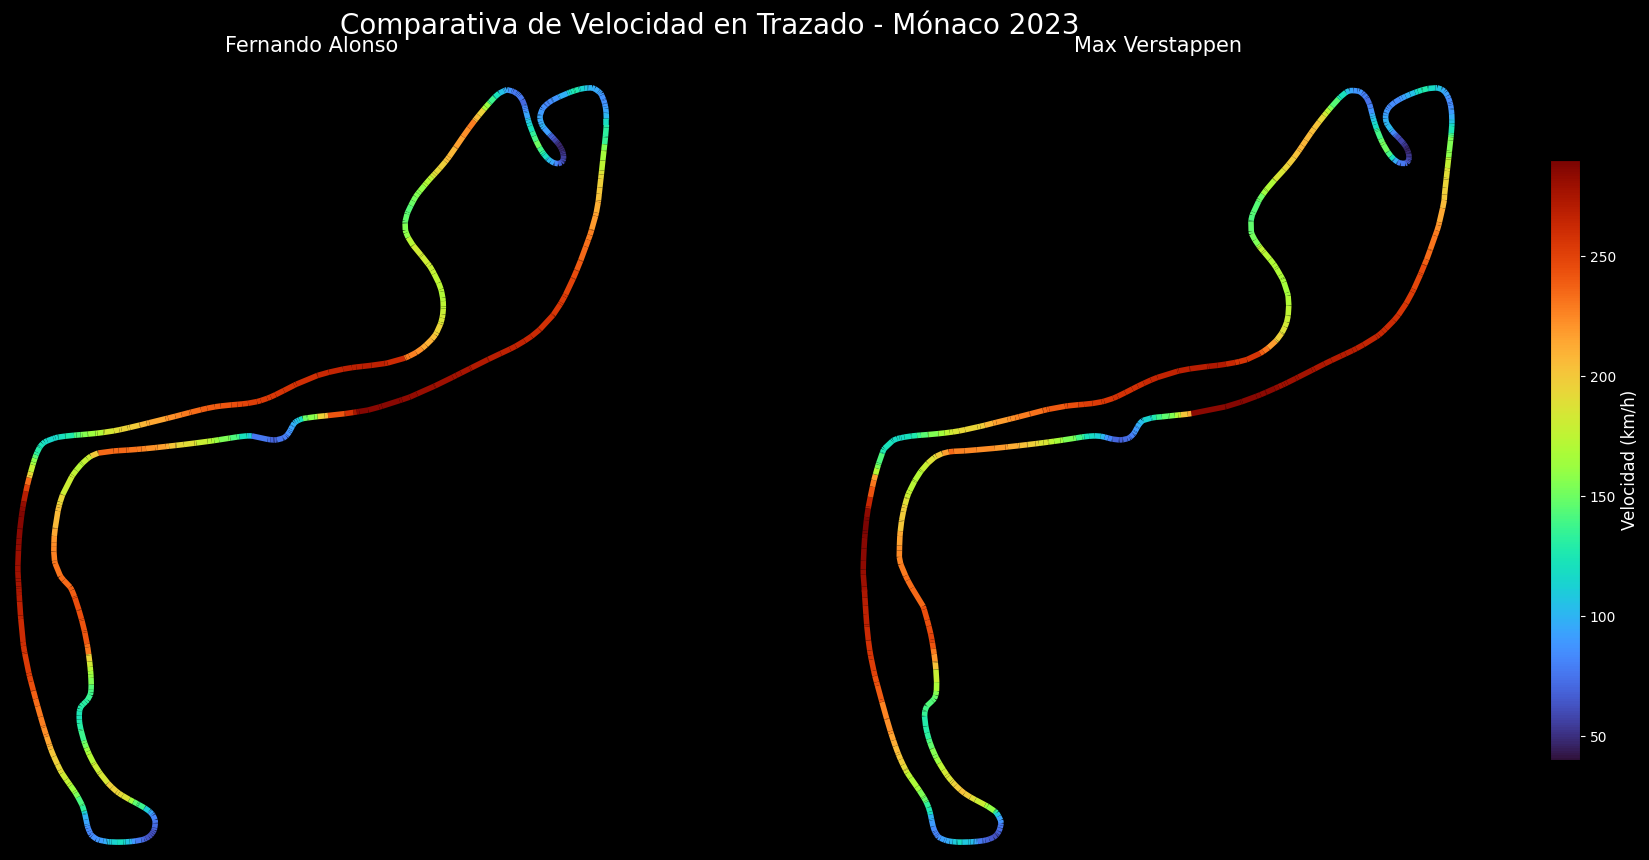

In [24]:
df_track = tel_alo[["X", "Y"]].dropna().drop_duplicates().reset_index(drop=True)

def prepare_driver_path(tel, driver):
    df = tel.copy()
    df["Driver"] = driver
    df["Time_s"] = df["Time"].dt.total_seconds()
    return df[["X", "Y", "Speed", "Throttle", "Brake", "nGear", "Time_s", "Distance", "Driver"]]

df_ver_path = prepare_driver_path(tel_ver, "VER")
df_alo_path = prepare_driver_path(tel_alo, "ALO")
df_paths = pd.concat([df_ver_path, df_alo_path], ignore_index=True)

def plot_speed_heatmap(ax, df_driver, title):
    df_driver = df_driver.sort_values('Distance')
    x = df_driver['X'].values
    y = df_driver['Y'].values
    color = df_driver['Speed'].values

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    norm = plt.Normalize(40, 290)
    lc = LineCollection(segments, cmap='turbo', norm=norm)
    lc.set_array(color)
    lc.set_linewidth(4)

    ax.add_collection(lc)
    ax.set_aspect('equal')
    ax.set_title(title, color='white', fontsize=15, pad=20)
    ax.axis('off')

    ax.set_xlim(x.min() - 100, x.max() + 100)
    ax.set_ylim(y.min() - 100, y.max() + 100)
    return lc

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), facecolor='black')

alo = df_paths[df_paths['Driver'] == 'ALO']
ver = df_paths[df_paths['Driver'] == 'VER']

lc_alo = plot_speed_heatmap(ax1, alo, "Fernando Alonso")
lc_ver = plot_speed_heatmap(ax2, ver, "Max Verstappen")

cbar_ax = fig.add_axes([0.92, 0.2, 0.015, 0.6])
cbar = fig.colorbar(lc_ver, cax=cbar_ax)
cbar.set_label('Velocidad (km/h)', color='white', size=12)
cbar.ax.yaxis.set_tick_params(color='white', labelcolor='white')

plt.suptitle("Comparativa de Velocidad en Trazado - Mónaco 2023", color='white', size=20, y=0.95)
plt.show()

In [25]:
fig_delta = px.line(df_delta,x="Distance",y="Delta",title="Delta de tiempo acumulado (VER - ALO)",labels={"Distance": "Distancia (m)", "Delta": "Delta tiempo (s)"})

fig_delta.add_hline(y=0, line_dash="dash")

fig_delta.add_vline(x=s1_end_dist, line_dash="dot", annotation_text="Fin S1", annotation_position="top")
fig_delta.add_vline(x=s2_end_dist, line_dash="dot", annotation_text="Fin S2", annotation_position="top")

for name, dist in corners.items():
    fig_delta.add_vline(x=dist, line_dash="dash", annotation_text=name, annotation_position="top")

fig_delta.show()


In [26]:
df_track = tel_alo[["X", "Y"]].dropna().drop_duplicates().reset_index(drop=True)

def prepare_driver_path(tel, driver):
    df = tel.copy()
    df["Driver"] = driver
    df["Time_s"] = df["Time"].dt.total_seconds()
    return df[["X", "Y", "Speed", "Throttle", "Brake", "nGear", "Time_s", "Distance", "Driver"]]

df_ver_path = prepare_driver_path(tel_ver, "VER")
df_alo_path = prepare_driver_path(tel_alo, "ALO")
df_paths = pd.concat([df_ver_path, df_alo_path], ignore_index=True)

def plot_track_with_paths(df_track, df_paths, color_var=None):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df_track["X"],y=df_track["Y"], mode="lines", name="Circuito", 
                             line=dict(color="rgba(180, 180, 180, 0.4)", width=12),hoverinfo="skip"))

    color_map = {"VER": "#0600EF", "ALO": "#00594F"}

    for drv in df_paths["Driver"].unique():
        df_drv = df_paths[df_paths["Driver"] == drv]

        if color_var is None:
            fig.add_trace(go.Scatter(x=df_drv["X"],y=df_drv["Y"],mode="lines",name=drv,
                line=dict(width=3, color=color_map.get(drv)),
                hovertemplate=("<b>Piloto: %{text}</b><br>" +"Velocidad: %{customdata[0]:.1f} km/h<br>" +
                               "Gas: %{customdata[1]:.0f}%<br>" +"Freno: %{customdata[2]}<br>" +
                               "Marcha: %{customdata[3]}<br>" +"<extra></extra>"),
                text=[drv]*len(df_drv),
                customdata=np.stack([df_drv["Speed"],df_drv["Throttle"],df_drv["Brake"].astype(int),df_drv["nGear"]], axis=-1)))
        else:
            fig.add_trace(go.Scattergl(x=df_drv["X"],y=df_drv["Y"],mode="markers",
                name=f"{drv} ({color_var})",
                marker=dict(size=4,color=df_drv[color_var],colorscale="Turbo",
                    showscale=(drv == df_paths["Driver"].unique()[0]),opacity=0.8),
                text=[drv]*len(df_drv),
                hovertemplate=f"<b>{drv}</b><br>{color_var}: %{{marker.color:.1f}}<extra></extra>"
            ))

    fig.update_layout(title="Comparativa de Trayectorias: Verstappen vs Alonso - Mónaco 2023",
        xaxis=dict(scaleanchor="y", scaleratio=1, showgrid=False, zeroline=False, visible=False),
        yaxis=dict(showgrid=False, zeroline=False, visible=False),
        template="plotly_dark",
        height=800,
        margin=dict(l=20, r=20, t=60, b=20)
    )

    fig.show()

plot_track_with_paths(df_track, df_paths)